In [2]:
import torch
import numpy as np
from drink_db import recipe, vector_holder, ingredient_handler,unit_converter,drink_index
import secrets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import secrets
from torch.utils.data import DataLoader
from IPython.display import clear_output
from numba import jit
from numba.typed import List

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0
True


In [2]:
class drink_generator :
    def __init__(self,num_flavors,max_ingredients) :
        self.num_flavors=num_flavors
        self.max_ingredients=max_ingredients
        self.randomizer= secrets.SystemRandom()
        
    def generate_empty(self) :
        vector=np.zeros([self.num_flavors])
        return vector
        
    def generate_ingredient(self) :
        #this is to skew towards more 0s
        vector=np.empty([self.num_flavors])
        for index in range(self.num_flavors) :
            val=self.randomizer.randint(-100,100)
            if val<0:val=0
            val=val/100
            vector[index]=val
        return vector
    
    def fill_out_recipe(self,recipe,fill_to=9) :
        if (diff:=fill_to-len(recipe))>0 :
            if isinstance(recipe,np.ndarray) :
                for i in range(diff) :
                    recipe=np.append(recipe,[self.generate_empty()], axis=0)
            else :
                for i in range(diff) :
                    recipe.append(self.generate_empty())
        return recipe
    
    
    def generate_recipe_matrix(self) :
        num_ingredients=self.randomizer.randint(2,self.max_ingredients)
        total_volume=0
        volumes=[]
        recipe=[]
        for i in range(num_ingredients) :
            volume=self.randomizer.randint(1,100)
            total_volume+=volume
            volumes.append(volume)
            ingredient=self.generate_ingredient()
            recipe.append(ingredient)
            
        for ingredient,volume in zip(recipe,volumes) :
            volume=volume/total_volume
#             print(volume)
#             print(ingredient)
            ingredient=ingredient*volume
#             print(ingredient)
        recipe=[x for _,x in sorted(zip(volumes,recipe), key=lambda pair: pair[0],reverse=True)]
        return recipe
    
    def convert_to_recipe(self,ingredient_matrix) :
        recipe=np.sum(ingredient_matrix, axis=0, keepdims=True) 
        return recipe
            
            
            
            

In [3]:
dg=drink_generator(31,7)
# for i in range(20) :
# print(dg.generate_recipe_matrix())

NameError: name 'drink_generator' is not defined

## Display methods ##

In [208]:
def plot_matrix(matrix,names=None,title="") :
    
    matrix[np.where(matrix > 0.005)]+=.4
#     print(matrix)
    plt.imshow(matrix, cmap='Blues', interpolation='nearest', origin='lower')

    if names is not None :
        plt.yticks(range(len(names)), names, fontsize='12')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
def print_data(matrix) :
    if isinstance(matrix, torch.Tensor) :
        matrix=matrix.detach().numpy()
    if len(list(matrix.shape))==4 :
        plot_matrix(matrix[0][0],title=matrix.shape)
    elif len(list(matrix.shape))==3 :
        plot_matrix(matrix[0],title=matrix.shape)
    elif len(list(matrix.shape))==2 :
        plot_matrix(matrix,title=matrix.shape)
    else :
        print("UNKNOWN SHAPE",matrix.shape)

# Permutation and distrobution information #
The number of ingredients forms a fairly normal distrobution with the numbers as follows:

## Numbers ##

| ingredients | number of recipes |
| --- | --- |
| 2 | 8 |
| 3 | 44 |
| 4 | 74 |
| 5 | 32 |
| 6 | 13 |
| 7 | 1 |


## Percentages ##

| ingredients | percentages |
| --- | --- |
| 2 | 4.5% |
| 3 | 25.0% |
| 4 | 42.0% |
| 5 | 18.0% |
| 6 | 7.0% |%
| 7 | .05% |


## Permutation distrobutions ##
4 ingredients can generate 24 permutations, so an attempt to keep the number of permutation similr for other drinks is in order, while still having a reasonable sampling of each recipe.

I ended up simply attempting to get the closes posible distrobution curves for total number of permutations, which was definitely not possble.

This ends up generating the following number of permutations for values greater than 4.

| ingredients | permutations |
| --- | --- |
| 5 | 28 |
| 6 | 30 |
| 7 | 25 |
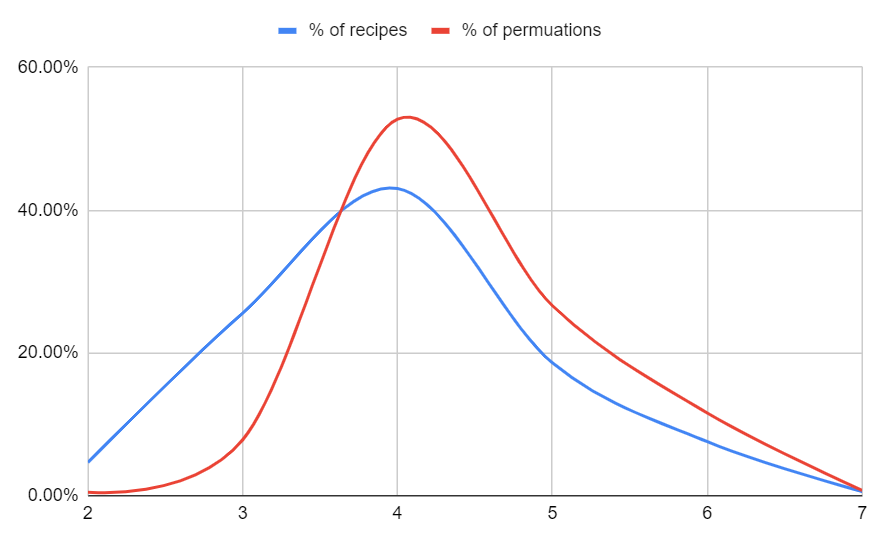


In [9]:
def get_permutations(matrix,fill_to=9,permutation_limits={5:28,6:30,7:25,8:120,9:120}) :
    '''This generates permutations of the passed in data. The max requirement is there as to not generate too many augmentations. 
    A recipe with 9 ingredients has 362880 permutations, which would significantly skew the dataset.'''
    permutations=list(itertools.permutations(matrix))
    selected_permutations=[]
    if len(matrix) in permutation_limits.keys() :
        num_to_get=permutation_limits[len(matrix)]
        
        while len(selected_permutations)<num_to_get :
            selected_permutations.append(secrets.choice(permutations))
    else :
        selected_permutations=permutations

    trimmed_permutations=[]
    if len(matrix)<fill_to :
            
        trimmed_permutations=[np.array([np.array(dg.fill_out_recipe(list(p),fill_to=fill_to))]) for p in selected_permutations]
    else :
        trimmed_permutations=[np.array([np.array(list(p))]) for p in selected_permutations]
    return np.array(trimmed_permutations)

In [4]:
perms=get_permutations(dg.fill_out_recipe(matrix,fill_to=8),fill_to=8)
full_shuffled_perms=np.array([np.swapaxes(p,0,1) for p in perms])
print(full_shuffled_perms.shape)

NameError: name 'get_permutations' is not defined

## Getting useable recipes ##

In [7]:
drink_db=drink_index(interactive=False)
search_terms=drink_db.parse_search("$vector")
results=drink_db.subset_search(search_terms)
print(results[0].ingredients)
print(len(results))

{'bourbon': [2.0, 'oz'], 'sugar': [1, 'cube'], 'angostura': [2.0, 'dashes']}
178


## Getting information about recipes and ingredients ##

In [89]:
ih=ingredient_handler()

def get_closest_recipe(recipe,recipe_list,ingredient_handler) :
	dist = np.linalg.norm(ingredient_handler.get_recipe_vector(recipe)-ingredient_handler.get_recipe_vector(recipe_list[0]))
	closest=recipe_list[0]
	for comp_recipe in recipe_list[1:] :
		if comp_recipe.id != recipe.id :
			new_dist = np.linalg.norm(ingredient_handler.get_recipe_vector(recipe)-ingredient_handler.get_recipe_vector(comp_recipe))
			if new_dist<dist :
				dist=new_dist
				closest=comp_recipe
	return closest,dist

def sort_by_closeness(recipe_list, ingredient_handler) :
    new_list=[recipe_list.pop()]
    dist_list=[]
    while len(recipe_list)>0 :
        current_recipe=new_list[-1]
        closest,dist=get_closest_recipe(current_recipe,recipe_list,ingredient_handler)
        new_list.append(recipe_list.pop(recipe_list.index(closest)))
        dist_list.append(dist)
    return new_list,dist_list


results,dists=sort_by_closeness(results,ih)

In [90]:
sorted_dists=sorted(dists)
# print(sorted_dists)
max_num=3
counter=0
for d in sorted_dists[3:]:
    i=dists.index(d)
    prev=results[i]
    dist_to=results[i+1]
    if prev.name != dist_to.name :
        print(prev)
        print(d)
        print(dist_to)
        counter+=1
    if counter>=max_num :
        break

corpse revivor #2
 codex
 page 188
 shake
 0.75 oz lillet blanc
 0.75 oz lemon juice
 0.75 oz gin
 0.75 oz cointreau
 2.0 dashes absinthe

0.015374473559114149
corpse reviver no2
 internet
 page 
 shaken
 3.0 cl lillet
 3.0 cl lemon juice
 3.0 cl gin
 3.0 cl cointreau
 1.0 dash absinthe

martini
 codex
 page 77
 stir and strain
 rated 3.00/5
 2.0 oz gin
 1.0 oz dry vermouth

0.018063388462946577
ideal gin martini
 codex
 page 62
 stir and strain
 2.0 oz gin
 1.0 oz dry vermouth
 1.0 dash orange bitters

gin sour
 diffords guide
 page 
 shaken
 2.0 oz gin
 1.0 oz lemon juice
 0.5 oz simple syrup
 3.0 dashes angostura

0.02956297773621396
fitzgerald
 diffords guide
 page 
 shaken
 1.66 oz gin
 25.0 ml lemon juice
 0.5 oz simple syrup
 2.0 dashes angostura



These results show that a distance of about 0.06 is the minimum required difference between different drinks that are not just variations on eachother.

In [201]:
distances=[]
ingredients=ih.ingredients
for ingredient in ingredients :
    for to_ingredient in ingredients :
        if ingredient is not to_ingredient :
#         if not bool(ingredient.names & to_ingredient.names) :
            dist = np.linalg.norm(ingredient.get_flavors()-to_ingredient.get_flavors())
            distances.append((ingredient,to_ingredient,dist))
            
            
combined_list=[(x,y,z) for x,y,z in sorted(distances, key=lambda pair: pair[2],reverse=False)]
# print(combined_list)
def print_info(to_print) :
    for one,two,dist in to_print :
        print(list(one.names)[0])
        print(dist)
        print(list(two.names)[0]) 
        print()


print_info(combined_list[-6:-1])
print(len(ingredients))

mint
2.315167380558045
orgeat syrup

orgeat syrup
2.315167380558045
mint

lemon
2.32379000772445
orgeat syrup

orgeat syrup
2.32379000772445
lemon

peychauds bitters
2.5059928172283334
orgeat syrup

46


Distances between ingredients range from ~0.6 to 2.5, however .9 seems to be a good cutoff for actually being similar

## generate recipe matrixes for all recipes and make dataloaders ##

In [92]:
def get_recipe_matrix(recipe,fill=False) :
    volumes,recipe_vector=ih.get_recipe_vectors(recipe,get_volumes=True)
    
    matrix=np.zeros((len(recipe_vector),31))
    for i in range(len(volumes)) :
        volume=[volumes[i]]
        vector=recipe_vector[i].get_flavors()
        row=np.insert(vector, 0, volume, axis=0)
#         print(len(row))
#         matrix[i]=[np.append(matrix,row)]
        matrix[i]=row
    
#     print(matrix)
#     print(matrix.shape)
    if fill :
        matrix=dg.fill_out_recipe(matrix)
    return matrix

In [93]:
matrix=get_recipe_matrix(results[0],False)
perms=get_permutations(dg.fill_out_recipe(matrix),fill_to=8)
print(perms.shape)
swapped=np.array([np.swapaxes(p,0,1) for p in perms])
swapped.shape

(120, 1, 9, 31)


(120, 9, 1, 31)

unaugmented (176, 1, 9, 31)
shuffle only ingredients (3371, 1, 9, 31)
shuffle in whitespace (0,)
1d
unaugmented (0,)
shuffle only ingredients (0,)
shuffle in whitespace (0,)
summed recipes (176, 1, 31)


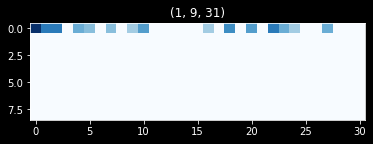

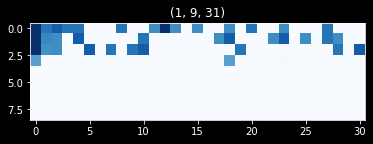

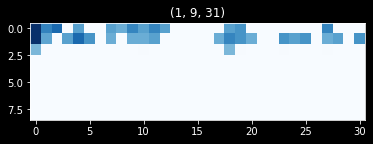

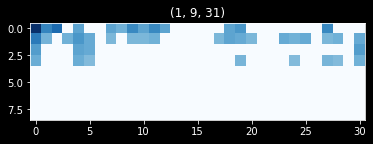

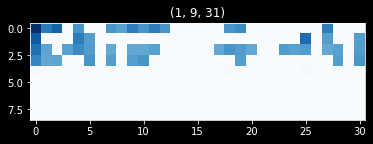

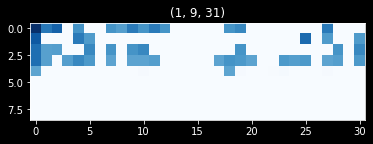

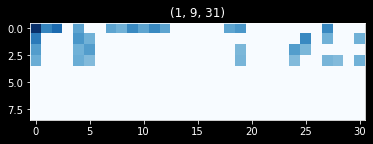

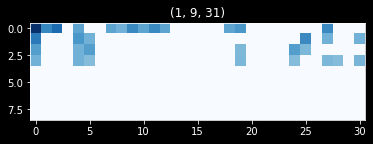

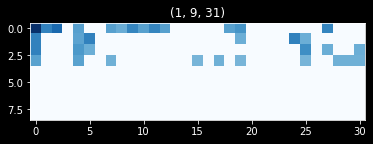

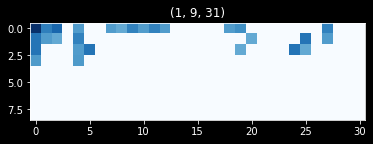

In [100]:
recipe_name_matrices=[]

unaugmented_matrices=[]
shuffled_matrices=[]
full_shuffled_matrices=[]

unaugmented_matrices1d=[]
shuffled_matrices1d=[]
full_shuffled_matrices1d=[]

recipe_matrices=[]


for recipe in results :
    matrix=get_recipe_matrix(recipe,False)
    recipe_name_matrices.append((recipe,dg.fill_out_recipe(matrix)))
    
    #The different datasets
    #2d
    #unaugmented
    unaugmented_matrices.append(np.array([dg.fill_out_recipe(matrix)]))
    
    #shuffle only ingredients
    shuffled_matrices.extend(get_permutations(matrix))
    
    #shuffle in whitespace
#     full_shuffled_matrices.extend(get_permutations(dg.fill_out_recipe(matrix)))
    
#     #1d
#     #unaugmented
#     un_augmented=np.array([dg.fill_out_recipe(matrix,8)])
# #     print(un_augmented.shape)
#     unaugmented_matrices1d.append(np.swapaxes(un_augmented,0,1))
    
#     #shuffle only ingredients
#     perms=get_permutations(matrix,8)
# #     print(perms.shape)
#     shuffled_perms=np.array([np.swapaxes(p,0,1) for p in perms])
# #     print(shuffled_perms.shape)
    
#     shuffled_matrices1d.extend(shuffled_perms)
    
#     #shuffle in whitespace
#     perms=get_permutations(dg.fill_out_recipe(matrix,fill_to=8),fill_to=8)
#     full_shuffled_perms=np.array([np.swapaxes(p,0,1) for p in perms])
#     full_shuffled_matrices1d.extend(full_shuffled_perms)
    
    
    
    #summed recipes
    recipe_matrices.append(dg.convert_to_recipe(matrix))
    

print("unaugmented",np.array(unaugmented_matrices).shape)
print("shuffle only ingredients",np.array(shuffled_matrices).shape)
print("shuffle in whitespace",np.array(full_shuffled_matrices).shape)
print('1d')
print("unaugmented",np.array(unaugmented_matrices1d).shape)
print("shuffle only ingredients",np.array(shuffled_matrices1d).shape)
print("shuffle in whitespace",np.array(full_shuffled_matrices1d).shape)
print("summed recipes",np.array(recipe_matrices).shape)

for i in range(10) :
    print_data(unaugmented_matrices[i])



In [74]:
print("unaugmented",np.array(unaugmented_matrices).shape)
print("shuffle only ingredients",np.array(shuffled_matrices).shape)
print("shuffle in whitespace",np.array(full_shuffled_matrices).shape)
print('1d')
print("unaugmented",np.array(unaugmented_matrices1d).shape)
print("shuffle only ingredients",np.array(shuffled_matrices1d).shape)
print("shuffle in whitespace",np.array(full_shuffled_matrices1d).shape)
print("summed recipes",np.array(recipe_matrices).shape)

unaugmented (176, 1, 9, 31)
shuffle only ingredients (176, 1, 9, 31)
shuffle in whitespace (0,)
1d
unaugmented (0,)
shuffle only ingredients (0,)
shuffle in whitespace (0,)
summed recipes (176, 1, 31)


2d
sorted by volume
randomized order, but followed by empty
torch.Size([32, 1, 9, 31])
torch.Size([32, 1, 31])


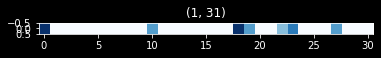

In [75]:
print("2d")

print("sorted by volume")
unaugmented_dataloader = DataLoader(unaugmented_matrices, batch_size=32, shuffle=True)

# data_iter=iter(unaugmented_dataloader)
# for i in range(180) :
#     try:
#         real_batch=next(data_iter)
#     except StopIteration:
#         data_iter=iter(unaugmented_dataloader)
#         real_batch=next(data_iter)
        
#     real_batch=next(data_iter)
#     print(real_batch.shape)



# print_data(real_batch[0])

print("randomized order, but followed by empty")

shuffled_dataloader = DataLoader(shuffled_matrices, batch_size=32, shuffle=True)
real_batch=next(iter(shuffled_dataloader))
print(real_batch.shape)


# print_data(real_batch[0])

# print("randomized order with shuffled empty")

# full_shuffle_dataloader = DataLoader(full_shuffled_matrices, batch_size=256, shuffle=True)
# real_batch=next(iter(full_shuffle_dataloader))
# print(real_batch.shape)

# print_data(real_batch[0])

# print("1d")
# print("sorted by volume")
# unaugmented_dataloader1d = DataLoader(unaugmented_matrices1d, batch_size=32, shuffle=True)
# real_batch=next(iter(unaugmented_dataloader1d))
# print(real_batch.shape)

# print_data(real_batch[0])

# print("randomized order, but followed by empty")

# shuffled_dataloader1d = DataLoader(shuffled_matrices1d, batch_size=128, shuffle=True)
# real_batch=next(iter(shuffled_dataloader1d))
# print(real_batch.shape)

# print_data(real_batch[0])

# print("randomized order with shuffled empty")

# full_shuffle_dataloader1d = DataLoader(full_shuffled_matrices1d, batch_size=256, shuffle=True)
# real_batch=next(iter(full_shuffle_dataloader1d))
# print(real_batch.shape)
# print_data(real_batch[0])


recipe_dataloader = DataLoader(recipe_matrices, batch_size=32, shuffle=True)
real_batch=next(iter(recipe_dataloader))
print(real_batch.shape)
print_data(real_batch[0])


## Now for the GAN ##

There are a couple ways I can go about this
## Generator ##
At the moment I can think of two methods to have the generator make an ingredient.

- The first of these is going from 1,100,1,1 to 1,1,9,31. I only need 8, however I am unable to acheive that with a consistant kernal.

- The second is to generate a 1d output with 8 channels, one per ingredient.

## Processing ##
Theres a couple ways to go about this.

- First and foremost; doing nothing. Just passing the raw data along. This is 2 possible outputs for the two generator methods.

- Second: Find the closest ingredient to the row and replace it with the appropriate values. I would only do this if the row is close enough to an ingredient, otherwise it would be made empty
   
Instead of passing each of the above along:
- Sum each matrix to be a 1,1,30,1 flavor vector, and use a dense NN to discriminate. 
    This has the benifit of being a more comprehensize flavor profile, without losing ingredient data.
    
## Descriminator ##
These options are basically limited by the processing
- 1,1,9,31
- 1,1,1,31
- or an ANN discriminator

HOWEVER: There are also data augmentation options. Though these only apply to the discriminator, they affect how the code would be generated.

### Augmentations ###
- Unshuffled, most to least volume
    - this is filled out with 0s for the 2d recipes
- shuffled
This generates a good number of augmentations, and may help avoid mode collapse.
    - For 2d recipes :
        - shuffle only the ingredients, fill bottom with blank space
        - shuffle blank space between recipes
        I truly have no idea if this will produce better or worse results, but I think its very likel it will require more training
    - for 1d recipes there is only shuffling or not 
    


# Conclusions #
It only makes sense to train them all.

- So there are 2d and 1d outputs (neither of which are truly that) and for each :
- replace, and not replace :
- and for each of those, sum and not sum
- and for all not sum, shuffle, not shuffle, and full shuffle

So a total of 14 combinations, which is perfectly within reason. 



In [42]:
shape_types=["2d","1d"]
to_replace=[True,False]
to_sum=[True,False]
to_shuffle=[True,False]
shuffle_2d=["partial shuffle","full shuffle"]

permutations=[]

for shape in shape_types :
    for replace in to_replace :
        for sum_val in to_sum :
            r="keep vectors"
            if replace : r="replace vectors"
            s="matrix"
            if sum_val : s="sum"
            
            a="" #augment
            if not sum_val : #if the data is not being summed into a single vector
                for shuffle in to_shuffle :
                    if shuffle : 
                        if shape=="1d" :
                            a="full shuffle"
                            description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                             print(description)
                            permutations.append(description)
                        else :
                            for shuffle_val in shuffle_2d :
                                a=shuffle_val
                                description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                                 name="{}\t{}\t\t{}\t{}\n".format(shape,r,s,a)
#                                 print(description)
                                permutations.append(description)
                                
                    else :
                        a="no shuffle"
                        description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                         print(description)
                        permutations.append(description)
                        
            else :
                description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                 print(description)
                permutations.append(description)
                    
            
for name in permutations :
    print(name)
print(len(permutations),"permutations")

2d	replace vectors		sum		

2d	replace vectors		matrix		partial shuffle

2d	replace vectors		matrix		full shuffle

2d	replace vectors		matrix		no shuffle

2d	keep vectors		sum		

2d	keep vectors		matrix		partial shuffle

2d	keep vectors		matrix		full shuffle

2d	keep vectors		matrix		no shuffle

1d	replace vectors		sum		

1d	replace vectors		matrix		full shuffle

1d	replace vectors		matrix		no shuffle

1d	keep vectors		sum		

1d	keep vectors		matrix		full shuffle

1d	keep vectors		matrix		no shuffle

14 permutations


In [14]:
def check_for_settings(goal_dimention,num_layers,start_dimention) :
    '''This function does the math to see if a set kernal settings can generate the wanted output after a certain number of layers'''
    kernal_range=[2,30]
    padding_range=[0,10]
    stride_range=[1,10]
    out_padding_range=[0,10]

    for kernal in range(kernal_range[0],kernal_range[1]) :
        for padding in range(padding_range[0],padding_range[1]) :
            for stride in range(stride_range[0],stride_range[1]) :
                for out_padding in range(out_padding_range[0],out_padding_range[1]) :
                    last_height=start_dimention
                    for i in range(num_layers) :
                        last_height=(last_height-1)*stride-2*padding+(kernal-1)+out_padding+1
                    if last_height==goal_dimention:#or last_height==29 :
                        print("kernal",kernal)
                        print("padding",padding)
                        print("stride",stride)
                        print("out_padding",out_padding)
#                         print("i",i+1)
                        print()

check_for_settings(30,4,1)    
    
# print(last_height)

# Start assembling network #
Build the generators and discriminators

In [16]:
# kernal_shape=(3,7)
# stride=(1,2)
# padding=(0,2)
# output_padding=(0,0)

kernal_shape2d=(3,3)
kernal_shape1d=(1,3)

stride=(1,2)
padding=(0,0)
output_padding=(0,0)

class Generator2D(nn.Module):
    def __init__(self):
        super(Generator2D, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128, kernal_shape2d, stride, padding, output_padding=output_padding,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,1, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator2D(nn.Module):
    def __init__(self):
        super(Discriminator2D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1,32, kernal_shape2d, stride, padding, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32,64, kernal_shape2d, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128, kernal_shape2d, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,1, kernal_shape2d, stride, padding, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    

class Generator1D(nn.Module):
    def __init__(self):
        super(Generator1D, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128, kernal_shape1d, stride, padding, output_padding=output_padding,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,8, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator1D(nn.Module):
    def __init__(self):
        super(Discriminator1D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(8,32, kernal_shape1d, stride, padding, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32,64, kernal_shape1d, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128, kernal_shape1d, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,1, kernal_shape1d, stride, padding, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
#Hidden neurons chosen to be <2x input
class DiscriminatorLinear(nn.Module):
    def __init__(self):
        super(DiscriminatorLinear, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(31,32),
            nn.Linear(32,16),
            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Helper function and device selection

In [17]:
#custom weights initialization
#taken from a pytorch tutorial
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#Select the available device
if torch.cuda.is_available() :
    device=torch.device("cuda")
else :device=torch.device("cpu")
    
print(device)

cuda


Assmebling GAN permutations

In [18]:
def get_nearest_ingredient(row,cutoff=0.7,get_label=False) :
    '''for converting generated arrays to the nearest ingredient, if they are close enough'''
    percent=row[0]
    pseudo_ingredient=(1/percent)*row[1:]
    lowest_dist=50
    nearest=None
    for ingredient in ih.ingredients :
        dist = np.linalg.norm(pseudo_ingredient-ingredient.get_flavors())
#         print(dist)
        if dist<lowest_dist :
            lowest_dist=dist
            nearest=ingredient
    

    if nearest is None or lowest_dist>cutoff :
        if get_label : 
            return np.zeros([31]),""
        else :
            return np.zeros([31])
    else :
        
        scaled_ingredient=[percent]
        scaled_ingredient.extend(percent*np.copy(nearest.get_flavors()))
#         print(scaled_ingredient)
        if get_label :
            return np.array(scaled_ingredient), list(nearest.get_names())[0]
        else :
            return np.array(scaled_ingredient)




def replace_rows(batch,**kwargs) :
#     batch=batch.detach().numpy()
    dummy_batch=batch.detach().cpu().numpy() #this saves too many copies between memories
    
    for ingredient_matrix,dummy_matrix in zip(batch,dummy_batch) :
            
        for i in range(ingredient_matrix.size(1)) :
            
            row=dummy_matrix[0][i]
            new_row=torch.from_numpy(get_nearest_ingredient(row,**kwargs)).float()
            ingredient_matrix.data[0][i]=new_row
            
    return batch
    
#Sums a matrix into a single 1d array
def convert_tensor_to_recipe(batch) :

    if batch.size(1)==1 :
         return torch.sum(batch, dim=2, keepdim=True)
    elif batch.size(1)==8:
        return torch.sum(batch, dim=1, keepdim=True)


#Basically a good method for skipping processing
def just_detach(batch) :
#     batch=batch.detach().numpy()
    return batch

#does not sum the data
def no_sum(batch) :
#     batch=batch.detach().numpy()
    return batch

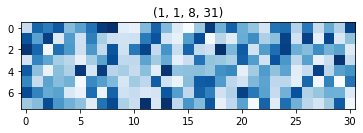

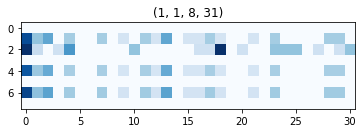

In [20]:
test_row=torch.rand(1,1,8,31,requires_grad=True)


print_data(test_row.detach().numpy())
ing=replace_rows(test_row,cutoff=3)
# print("out",ing)
# test_row.data=torch.from_numpy(ing).float()
# print(test_row.grad)
# gen=Generator2D()
# ran=torch.rand(2,100,1,1)
# out=gen(ran)

# print_data(out.detach().numpy())
# converted=convert_tensor_to_recipe(out)
print_data(ing.detach().numpy())

In [189]:
for permutation in permutations :
    print(permutation)

2d	replace vectors		sum		

2d	replace vectors		matrix		partial shuffle

2d	replace vectors		matrix		full shuffle

2d	replace vectors		matrix		no shuffle

2d	keep vectors		sum		

2d	keep vectors		matrix		partial shuffle

2d	keep vectors		matrix		full shuffle

2d	keep vectors		matrix		no shuffle

1d	replace vectors		sum		

1d	replace vectors		matrix		full shuffle

1d	replace vectors		matrix		no shuffle

1d	keep vectors		sum		

1d	keep vectors		matrix		full shuffle

1d	keep vectors		matrix		no shuffle



In [19]:
device=torch.device('cuda')
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


real_label = 1.
fake_label = 0.

In [211]:


model_permutations=[]
for permutation in permutations :
    model_data={}
    model_data["name"]=permutation.replace('\t', ' ').replace('  ', ' ').strip()
    print(model_data["name"])
    model_data["generator loss"]=[]
    model_data["discriminator loss"]=[]
    model_data["activated"]=True
    
    model_data["criterion"]=nn.BCELoss()



    if 'sum' in permutation :
        model_data["sum function"]=convert_tensor_to_recipe
        model_data["discriminator"]=DiscriminatorLinear().to(device)
        model_data["dataloader"]=DataLoader(recipe_matrices, batch_size=645, shuffle=True)
        if '1d' in permutation :
            model_data["generator"]=Generator1D().float().to(device)
        elif '2d' in permutation :
            print("2d sum")
            model_data["generator"]=Generator2D().float().to(device)
        else :print("Something went wrong 0")
                

    else : #if sum is not in there
        model_data["sum function"]=None
        if '1d' in permutation :
            #1D NN
            model_data["discriminator"]=Discriminator1D().float().to(device)
            model_data["generator"]=Generator1D().float().to(device)

            if 'partial shuffle' in permutation :
                model_data["dataloader"]=DataLoader(shuffled_matrices1d, batch_size=128, shuffle=True)
                
            elif  'full shuffle' in permutation :
                model_data["dataloader"]=DataLoader(full_shuffled_matrices1d, batch_size=256, shuffle=True)
                
            elif  'no shuffle' in permutation :
                model_data["dataloader"]=DataLoader(unaugmented_matrices1d, batch_size=32, shuffle=True)
            else :print("Something went wrong 1")
                
        elif '2d' in permutation :
            #2D NN
            model_data["discriminator"]=Discriminator2D().float().to(device)
            model_data["generator"]=Generator2D().float().to(device)
            
            if 'partial shuffle' in permutation :
                model_data["dataloader"]=DataLoader(shuffled_matrices, batch_size=128, shuffle=True)
                
            elif  'full shuffle' in permutation :
                model_data["dataloader"]=DataLoader(full_shuffled_matrices, batch_size=256, shuffle=True)
                
            elif  'no shuffle' in permutation :
                model_data["dataloader"]=DataLoader(unaugmented_matrices, batch_size=32, shuffle=True)
            else :print("Something went wrong 2")
                
    if "replace vectors" in permutation :
        model_data["processing"]=replace_rows
    elif "keep vectors" in permutation :
        model_data["processing"]=None
    
    #apply mormaly distrobution of weights
    model_data["discriminator"].apply(weights_init)
    model_data["generator"].apply(weights_init)
    
    #set up optmizers
    model_data["discriminator optimizer"]=optim.Adam(model_data["discriminator"].parameters(), lr=lr, betas=(beta1, 0.999))
    model_data["generator optimizer"]=optim.Adam(model_data["generator"].parameters(), lr=lr, betas=(beta1, 0.999))
    
    model_data["data iterator"]=None#iter(model_data["dataloader"])
    



    model_permutations.append(model_data)
    


2d replace vectors sum
2d sum
2d replace vectors matrix partial shuffle
2d replace vectors matrix full shuffle
2d replace vectors matrix no shuffle
2d keep vectors sum
2d sum
2d keep vectors matrix partial shuffle
2d keep vectors matrix full shuffle
2d keep vectors matrix no shuffle
1d replace vectors sum
1d replace vectors matrix full shuffle
1d replace vectors matrix no shuffle
1d keep vectors sum
1d keep vectors matrix full shuffle
1d keep vectors matrix no shuffle


In [193]:
# for model_data in model_permutations:
#     print(model["name"])
for key in model_permutations[0].keys() :
    print(key)
#         print(value)
#         print()
#     print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")        

name
generator loss
discriminator loss
activated
criterion
sum function
discriminator
dataloader
generator
processing
discriminator optimizer
generator optimizer
data iterator


In [194]:
torch.cuda.is_available()
torch.cuda.device(0)
# torch.multiprocessing.set_start_method('spawn')
torch.cuda.device_count()
torch.cuda.get_device_name()

'GeForce GTX 1080'

In [20]:
def gen_labels(label_state,size) :
    if label_state : #true
        return torch.FloatTensor(size,).uniform_(1., 1.0)
    else : #False
        return torch.FloatTensor(size,).uniform_(0.0, 0.0)
        

def load_data(model_data,dataloader_text="dataloader",iterator_text="data iterator") :
    '''Load in next batch of data'''
    if model_data[iterator_text]==None :
        model_data[iterator_text]=iter(model_data[dataloader_text])
    try:
        real_batch=next(model_data[iterator_text])
    except StopIteration:
        model_data[iterator_text]=iter(model_data[dataloader_text])
        real_batch=next(model_data[iterator_text])
        
#     labels=gen_labels(True,real_batch.size(0)) #if the data is loaded its true
    return real_batch.to(device)# ,labels.to(device)
        

def save_data(model_permutations,epoch,folder="permutation_progress") :
    #Cannot save iterators for some reason.
    name="{}/model_permutations_E{}".format(folder,epoch)
    for model_data in model_permutations:
        model_data["data iterator"]=None 
    torch.save(model_permutations,name)
    
def save_data_dict(models,epoch,folder="permutation_progress") :
    #Cannot save iterators for some reason.
    name="{}/model_dict_E{}".format(folder,epoch)
    for model_data in models.values():
        model_data["data iterator"]=None
        model_data["sum iterator"]=None 
    torch.save(models,name)
    
def plot_model_data(model_data) :
    
    plt.plot(model_data["discriminator loss"],label="discriminator")
    plt.plot(model_data["generator loss"],label="generator")
    plt.xlabel("epoch")
    plt.title(model_data["name"])
#     print(model_data["name"])
    plt.legend()
    plt.show()
    

In [213]:

epoch=0
num_epochs=40000
save_data(model_permutations,epoch)
prev_epoch=epoch
# plot_model_data(model_permutations[0])

In [16]:
num_epochs=1000000
model_permutations=torch.load("permutation_progress/model_permutations_E80000")
prev_epoch=80000

2d keep vectors matrix partial shuffle
1.71 oz gin
1.75 oz light rum
0.89 oz lime
0.00 oz sparkling water
0.00 oz egg white


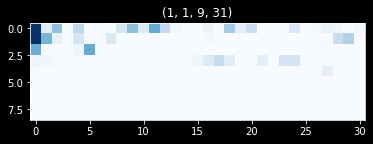

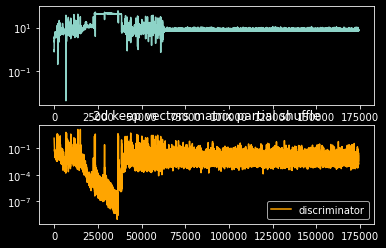

2d keep vectors matrix full shuffle
0.62 oz light rum
0.52 oz sugar cube
3.20 oz egg white


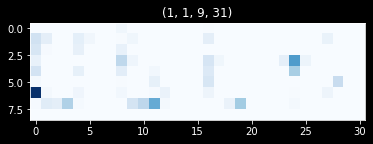

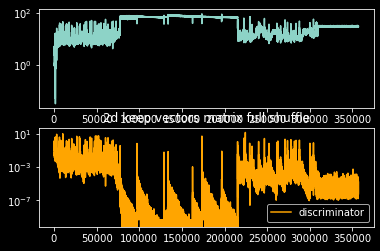

2d keep vectors matrix no shuffle
2.95 oz vodka
0.19 oz sugar cube
0.01 oz egg white


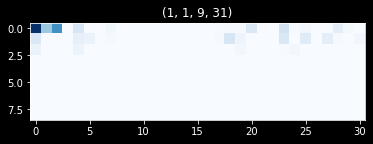

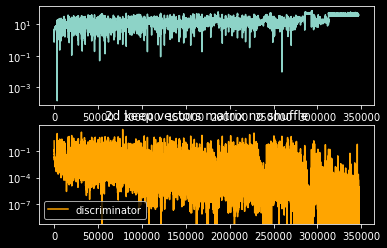

epoch 425000
epoch 425100
epoch 425200
epoch 425300


KeyboardInterrupt: 

In [61]:
#TRAIN
for epoch in range(prev_epoch,num_epochs):
    prev_epoch=epoch

    #iterate over models
    for model_data in model_permutations:
        if model_data["activated" ] :
#             print(model_data["name"])
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch

            #zero gradients
            model_data["discriminator"].zero_grad()


            # Format batch
            real_batch,_=load_data(model_data)
            b_size = real_batch.size(0)
            real_batch=real_batch.to(device)
            
            labels = torch.full((b_size,), 1., dtype=torch.float, device=device)
            

            # Forward pass real batch through D
            output = model_data["discriminator"](real_batch.float()).view(-1)

            # Calculate loss on all-real batch
            errD_real = model_data["criterion"](output, labels)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 100, 1, 1, device=device)

            # Generate fake image batch with generator
            fake_batch = model_data["generator"](noise)
#             print(fake_batch.shape)
            #generate labels for fake batch
#             fake_labels=gen_labels(False,b_size).to(device)
            labels.fill_(0.) #fill with fake tag

    #       process data            
            if model_data["processing"] is not None :
                fake_batch=model_data["processing"](fake_batch)

                if model_data["sum function"] is not None :
                    fake_batch=model_data["sum function"](fake_batch) #or not summed, if the function doesn't sum it
#                 fake_batch=torch.from_numpy(fake_batch).to(device) #should be very detached
         
            elif  model_data["sum function"]  is not None : #this looks dumb but should save some time
                fake_batch=model_data["sum function"](fake_batch) #or not summed, if the function doesn't sum it

            #pass generated and processed data into the disciminator
            output = model_data["discriminator"](fake_batch.detach()).view(-1) #this should be detached as this is not training the discriminator

            # Calculate D's loss on the all-fake batch
#             print(fake_labels.shape)
#             print(output.shape)
#             print(model_data["name"])
            errD_fake = model_data["criterion"](output, labels)

            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            model_data["discriminator optimizer"].step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            model_data["generator"].zero_grad()

    #         label.fill_(real_label)  # fake labels are real for generator cost
#             labels=gen_labels(True,b_size).to(device)
#             labels = torch.full((b_size,), 1., dtype=torch.float, device=device)
            labels.fill_(1.) #fill with real tag
    

            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = model_data["discriminator"](fake_batch).view(-1)
            # Calculate G's loss based on this output
            errG = model_data["criterion"](output, labels)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()

            # Update G
            model_data["generator optimizer"].step()


            # Save Losses for plotting later
            model_data["generator loss"].append(errG.item())
            model_data["discriminator loss"].append(errD.item())

    # Output training stats & save
    if epoch % 1000 == 0:
#         print("epoch",epoch)
        save_data(model_permutations,epoch)
        clear_output()
        plotted=""

        noise = torch.randn(1,100, 1, 1, device=device)
#         for model_data in model_permutations:

        for model_data in model_permutations:
            if model_data["activated"] :
                with torch.no_grad():
                    print(model_data["name"])
                    generator=model_data["generator"]
                    generated=generator(noise)
                    print_recipe_vals(generated.cpu().detach(),4)
                    print_data(generated.cpu().detach())
                    print("\n")
                
                #plot
                if "keep vectors" in model_data["name"] and model_data["name"] not in plotted:
                    pair_name=model_data["name"].replace("keep vectors","replace vectors")
                    
                    pair=None
                    for m in model_permutations:
                        if m["name"]==pair_name :
                            if m["activated"] :
                                pair=m
                                break
                            
                    if pair is not None :
                        fig, (ax1, ax2) = plt.subplots(2)
                        ax3 = ax1.twinx() 
                        ax4 = ax2.twinx() 
                        title=model_data["name"].replace("keep vectors","")
                        fig.suptitle(title)
                        N=50
                        ax1.plot(pair["generator loss"][N:],label="generator loss")
                        ax3.plot(pair["discriminator loss"][N:],label="discriminator loss",color="orange")
                        ax2.plot(model_data["generator loss"][N:],label="generator loss")
                        ax4.plot(model_data["discriminator loss"][N:],label="discriminator loss",color="orange")
                        
                        plotted+=model_data["name"]+" "
                        plotted+=pair["name"]+" "
                        
                        ax1.set_title("replace vectors")
                        ax2.set_title("keep vectors")
#                         ax1.xlabel("epoch")
#                         ax.xlabel("epoch")
                        ax1.legend()
                        ax2.legend()
                        ax3.legend(loc=0)
                        ax4.legend(loc=0)
                        plt.style.use('dark_background')
                        ax1.set_yscale('log')
                        ax2.set_yscale('log')
                        ax3.set_yscale('log')
                        ax4.set_yscale('log')
                        plt.show()
                    else :
                        fig, (ax1,ax2) = plt.subplots(2)
#                         ax2=ax1.twinx()
                        plotted+=model_data["name"]+" "
                        ax2.plot(model_data["discriminator loss"],label="discriminator",color="orange")
                        ax1.plot(model_data["generator loss"],label="generator")
                        ax1.set_xlabel("epoch")
#                         ax2.set_xlabel("epoch")
                        plt.title(model_data["name"])                        
                        plt.legend()
#print(model_data["name"])ax11.set_yscale('log')
                        ax1.set_yscale('log')
                        ax2.set_yscale('log')
                        
                        plt.style.use('dark_background')
                        plt.show()
    if epoch%100==0 :
        print("epoch",epoch)
         

In [27]:
save_data(model_permutations,epoch)

In [21]:
def update_learning_rate(optimizer,lr) :
    for param_group in optimizer.param_groups:
        param_group['lr']=lr
        print(param_group['lr'])

In [22]:
def print_recipe_vals(generated,multiplier) :
    ingredients={}
    d=2
    if generated.size(1)==8 :
        d=1
        for i in range(generated.size(d)):
            ingredient=generated[0][i][0]
            actual_ingredient,name=get_nearest_ingredient(ingredient,cutoff=.7,get_label=True)
            if name != "" :
                if name =="white" :
                    name="egg white"
                if name in ingredients.keys() :
                    ingredients[name]+=multiplier*actual_ingredient[0]
                else :
                     ingredients[name]=multiplier*actual_ingredient[0]

    else :
        for i in range(generated.size(d)):
            ingredient=generated[0][0][i]
            actual_ingredient,name=get_nearest_ingredient(ingredient,cutoff=.7,get_label=True)
            if name != "" :
                if name =="white" :
                    name="egg white"
                if name in ingredients.keys() :
                    ingredients[name]+=multiplier*actual_ingredient[0]
                else :
                     ingredients[name]=multiplier*actual_ingredient[0]
    
    for name,volume in ingredients.items() :
        print("{:.2f} oz {}".format(volume,name))


In [51]:
for model_data in model_permutations:
    if "2d keep vectors matrix partial shuffle"== model_data["name"] :
        update_learning_rate(model_data["discriminator optimizer"],.0001)

0.0001


In [23]:
def replace_data(copy_to,copy_from,data_name) :
    copy_to_data=None
    copy_from_data=None
    for model_data in model_permutations:
        if "replace vectors" in model_data["name"] :# and "replace" in model_data["name"] :
                model_data["activated"]=False
#     elif "keep vectors" in permutation :
#         model_data["processing"]=None
        
#     if 'sum' in model_data["name"] :
#         model_data["sum function"]=convert_tensor_to_recipe

In [59]:
from copy import deepcopy
model_permutations_old=torch.load("permutation_progress/model_permutations_E314000")

for model_data,old_data in zip(model_permutations,model_permutations_old):
    if "2d keep vectors matrix no shuffle"== model_data["name"] :

        model_data["discriminator"]=deepcopy(old_data["discriminator"])
        model_data["generator"]=deepcopy(old_data["generator"])
        model_data["generator loss"]=deepcopy(old_data["generator loss"])
        model_data["discriminator loss"]=deepcopy(old_data["discriminator loss"])
        
        update_learning_rate(model_data["discriminator optimizer"],.0001)
        update_learning_rate(model_data["generator optimizer"],.0001)
        print(model_data['name'])
        print(model_data['activated'])
        print(model_data['processing'])
        print(model_data['sum function'])
        print('#############################\n')

0.0001
0.0001
2d keep vectors matrix no shuffle
True
None
None
#############################



In [92]:
a=np.array([1,2,0,1])
b=np.array([1,1,4,1])

print(np.linalg.norm(a-b))

squared=0
for i in range(len(a)) :
    squared+=(a[i]-b[i])**2
# print(squared
print(np.sqrt(squared))

4.123105625617661
4.123105625617661


In [138]:
ingredient_list=[i.get_flavors() for i in ih.ingredients if 'egg white' not in i.get_names()]
# [print(i.get_names()) for i in ih.ingredients if 'egg white' in i.get_names()]
# @jit is actually much slower in this case it seems.
def calc_overlap(batch,ingredient_list,cutoff=0.9) :
    total_rows=0
    correct_rows=0
    for i in range(batch.shape[0]) :
        matrix=batch[i][0]
        for row in matrix:
            if np.sum(row)>0.1 :
                percent=row[0]
                pseudo_ingredient=(1/percent)*row[1:]

                total_rows+=1.0
                for ingredient in ingredient_list :
                    dist = np.linalg.norm(pseudo_ingredient-ingredient)
    #                 print(dist)
                    if dist<cutoff :
                        correct_rows+=1
                        break
#     print(total_rows)
    if correct_rows>0 :
        return correct_rows/total_rows
    else : return 0.0
                
            
# noise = torch.randn(600,100, 1, 1, device=device)
# with torch.no_grad():
#     print(model_permutations[0]["name"])
#     av_time=0
#     generator=model_permutations[0]["generator"]
#     generated=generator(noise)
#     print_data(generated.cpu().detach())
#     percent=calc_overlap(generated.cpu().detach().numpy(),ingredient_list,cutoff=2)


#     print(percent)
#     print(1/percent)
#     print("\n")

epoch 280000
2d keep vectors matrix no shuffle
2.11 oz light rum
0.48 oz lime
0.00 oz egg white


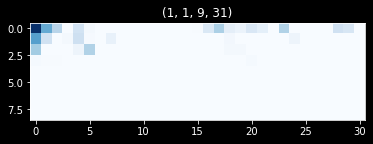



epoch 282000
2d keep vectors matrix no shuffle
0.81 oz sparkling water
0.65 oz vodka
0.27 oz sugar cube
0.28 oz lime
0.00 oz egg white


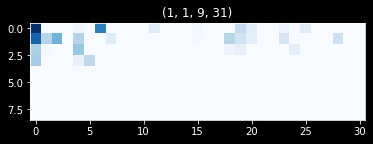



epoch 284000
2d keep vectors matrix no shuffle
2.07 oz vermouth rouge
0.40 oz lemon juice
0.33 oz sugar cube
0.00 oz egg white


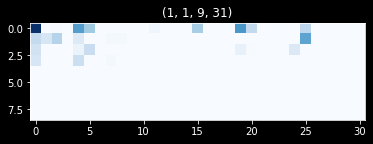



epoch 286000
2d keep vectors matrix no shuffle
0.00 oz egg white


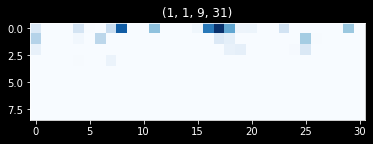

KeyboardInterrupt: 

In [187]:
for e in range(280000,316000,2000) :
    noise = torch.randn(1,100, 1, 1, device=device)
    model_permutations_old=torch.load("permutation_progress/model_permutations_E{}".format(e))
    print("epoch",e)
    for model_data in model_permutations_old :
        if "2d keep vectors matrix no shuffle"== model_data["name"] :
            
            with torch.no_grad():
                print(model_data["name"])
                generator=model_data["generator"]
                generated=generator(noise)
                print_recipe_vals(generated.cpu().detach(),4)
                print_data(generated.cpu().detach())
                print("\n")

In [24]:
models=torch.load("triple/model_dict_E0")


In [193]:
# models={}
# # sum_desc=None
# # sum_gen_loss=None
# # sum_desc_loss=None
# # sum_dataloader=None
# # sum_discriminator_optimizer=None
# # sum_function=None
# print(sum_function)
# sum_discriminator=None
# for model_data in model_permutations_old :
#     name=model_data["name"].replace("2d keep vectors matrix ","")
#     if '1d' not in name :
#         if 'replace' not in name :
#             if 'full' not in name :
#                 if 'sum' in name :
# #                     model_data["sum discriminator loss"]=deepcopy(sum_desc_loss)
# #                     model_data["sum dataloader"]=deepcopy(sum_dataloader)
# #                     model_data["sum discriminator optimizer"]=deepcopy(sum_discriminator_optimizer)
# #                     model_data["sum function"]=sum_function
# #                     model_data["multiply loss"]=False
#                     sum_discriminator=model_data["discriminator"]
                    

#                     print(name)
#                     print(model_data.keys())
#                     print()
#                     models[name]=model_data
# #                 else :sum_desc_loss=model_data["discriminator loss"]

# if 'partial shuffle' in permutation :
#     model_data["dataloader"]=DataLoader(shuffled_matrices, batch_size=128, shuffle=True)


# elif  'no shuffle' in permutation :
#     model_data["dataloader"]=DataLoader(unaugmented_matrices, batch_size=32, shuffle=True)
# else :print("Something went wrong 2")

    


print(models.keys())
# models["no shuffle multiply"] = deepcopy(models["no shuffle"])
# del models["partial shuffle multiply"]
for model_data in models.values():
    model_data["data iterator"]=None 
    model_data["sum iterator"]=None 

# new_list=[]                   
for name,model_data in models.items() :
    print(name)
    for key,value in model_data.items() :
#         print(key)
        if "loss" in key:
#             print(key)
            model_data[key]=[]
    if "multiply" in name :
        model_data["multiply loss"]=True
        print(model_data["multiply loss"])
     
    model_data["sum dataloader"]=DataLoader(recipe_matrices, batch_size=32, shuffle=True)
    if "shuffle" in name :
        model_data["dataloader"]=DataLoader(shuffled_matrices, batch_size=32, shuffle=True)
    else :

        model_data["dataloader"]=DataLoader(unaugmented_matrices, batch_size=32, shuffle=True)

    model_data["discriminator"]=Discriminator2D().float().to(device)
    model_data["sum discriminator"]=DiscriminatorLinear().float().to(device)
    model_data["generator"]=Generator2D().float().to(device)
    model_data["discriminator"].apply(weights_init)
    model_data["sum discriminator"].apply(weights_init)
    model_data["generator"].apply(weights_init)


    model_data["sum discriminator optimizer"]=optim.Adam(model_data["sum discriminator"].parameters(), lr=.0002, betas=(beta1, 0.999)) #SUM
    model_data["discriminator optimizer"]=optim.Adam(model_data["discriminator"].parameters(), lr=.0002, betas=(beta1, 0.999)) #DISC
    model_data["generator optimizer"]=optim.Adam(model_data["generator"].parameters(), lr=0.0002, betas=(beta1, 0.999)) #GEN
    model_data["sum function"]=convert_tensor_to_recipe


dict_keys(['partial shuffle', 'no shuffle', 'partial shuffle multiply', 'no shuffle multiply'])
partial shuffle
no shuffle
partial shuffle multiply
True
no shuffle multiply
True


In [194]:
num_epochs=1000000
# model_permutations=torch.load("triple/model_permutations_E49920")
prev_epoch=0
save_data_dict(models,prev_epoch,folder="triple")


partial shuffle
2.37 oz white rum
0.34 oz egg


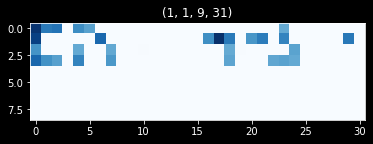

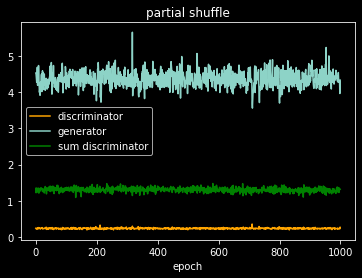


no shuffle
0.00 oz egg


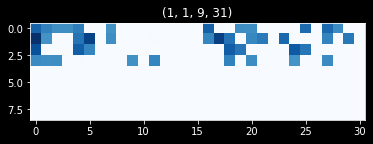

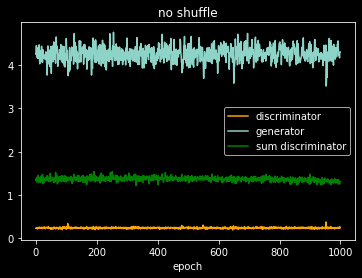

epoch 999000
epoch 999100
epoch 999200
epoch 999300
epoch 999400
epoch 999500
epoch 999600
epoch 999700
epoch 999800
epoch 999900


In [221]:
#TRAIN
for epoch in range(prev_epoch,num_epochs):
    prev_epoch=epoch

    #iterate over models
    for model_data in models.values():
        if model_data["activated" ] :
#             print(model_data["name"])
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch

            #update sum discriminator

            
            
            #Update matrix discriminator
            model_data["discriminator"].zero_grad()

            # Format batch
            real_batch=load_data(model_data)
#             print_data(real_batch.detach().cpu())
            b_size = real_batch.size(0)
            real_batch=real_batch.to(device)
           
            #labels = torch.full((b_size,), 1., dtype=torch.float, device=device)
            labels=torch.empty((b_size,), dtype=torch.float, device=device).uniform_(0.95, 1.00)
            
            # Forward pass real batch through D
            output = model_data["discriminator"](real_batch.float()).view(-1)
            
            # Calculate loss on all-real batch
            errD_real = model_data["criterion"](output, labels)
            


            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            
            ## TRAIN DISCRIMINATOR ON GENERATOR ##

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 100, 1, 1, device=device)

            # Generate fake image batch with generator
            fake_batch = model_data["generator"](noise)
            

            
            #labels.fill_(0.) #fill with fake tag
            labels=torch.empty((b_size,), dtype=torch.float, device=device).uniform_(0., 0.05)
            
            #pass generated and processed data into the disciminator
            output = model_data["discriminator"](fake_batch.detach()).view(-1) #this should be detached as this is not training the discriminator
            
            errD_fake = model_data["criterion"](output, labels)
            
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
#             D_G_z1 = output.mean().item()

            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            model_data["discriminator optimizer"].step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            model_data["generator"].zero_grad()

            ## TRAIN GENERATOR ON DISCRIMINATOR ##
            
            labels=torch.empty((b_size,), dtype=torch.float, device=device).uniform_(0.95, 1.0)
    
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = model_data["discriminator"](fake_batch).view(-1)
            
            # Calculate G's loss based on this output
            errG = model_data["criterion"](output, labels)

            if model_data["multiply loss"] :
                errG=errG**2
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            
            model_data["generator optimizer"].step()
            
            ### SUM DISCRIMINATOR PASS  ####################################################################
            ## TRAIN DISCRIMINATOR ON REAL ##
            
            model_data["sum discriminator"].zero_grad()
            
            #load data
            sum_real_batch=load_data(model_data,dataloader_text="sum dataloader",iterator_text="sum iterator")
            sum_b_size = sum_real_batch.size(0)
            sum_real_batch=sum_real_batch.to(device)

            #init labels
            #sum_labels = torch.full((sum_b_size,), 1., dtype=torch.float, device=device)
            sum_labels =torch.empty((sum_b_size,), dtype=torch.float, device=device).uniform_(.9, 1.1)
            
            #pass through
            sum_output = model_data["sum discriminator"](sum_real_batch.float()).view(-1)
            sum_errD_real = model_data["criterion"](sum_output, sum_labels)
            sum_errD_real.backward()
            
            ## TRAIN DISCRIMINATOR ON GENERATOR ##
            noise = torch.randn(sum_b_size, 100, 1, 1, device=device)

            # Generate fake image batch with generator
            fake_batch = model_data["generator"](noise)
            
            sum_labels =torch.empty((sum_b_size,), dtype=torch.float, device=device).uniform_(0., .1)
            sum_fake_batch=model_data["sum function"](fake_batch)
            
            #pass generated and processed data into the disciminator
            sum_output = model_data["sum discriminator"](sum_fake_batch.detach()).view(-1) #this should be detached as this is not training the discriminator
            sum_errD_fake = model_data["criterion"](sum_output, sum_labels)

            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            sum_errD_fake.backward()
#             D_G_z1 = output.mean().item()

            # Compute error of D as sum over the fake and the real batches
            sum_errD = sum_errD_real + sum_errD_fake
            # Update D
            model_data["sum discriminator optimizer"].step()
            
            if epoch>10000 :

                ## TRAIN GENERATOR ON DISCRIMINATOR ##

                sum_labels =torch.empty((sum_b_size,), dtype=torch.float, device=device).uniform_(.9, 1.1)
                sum_output = model_data["sum discriminator"](sum_fake_batch).view(-1)
                sum_errG = model_data["criterion"](sum_output, sum_labels)  
                sum_errG.backward()

                # Update G
                model_data["generator optimizer"].step()


            # Save Losses for plotting later
            model_data["sum discriminator loss"].append(sum_errD.item())
            model_data["generator loss"].append(errG.item()+sum_errG.item())
            model_data["discriminator loss"].append(errD.item())

    # Output training stats & save
    if epoch % 1000 == 0:
#         print("epoch",epoch)
        save_data_dict(models,epoch,folder="triple")
    
    if epoch % 1000 == 0:
        clear_output()

        noise = torch.randn(1,100, 1, 1, device=device)
#         for model_data in model_permutations:

        for model_data in models.values():
            if model_data["activated"] :

            #print LR
#                 for key, item in model_data.items() :
#                     if "optimizer" in key :
#                         print(key)
#                         for param_group in item.param_groups:
#                             print("lr=",param_group['lr'],"\n")
                print()
                
                with torch.no_grad():
                    print(model_data["name"])
                    generator=model_data["generator"]
                    generated=generator(noise)
                    print_recipe_vals(generated.cpu().detach(),4)
                    print_data(generated.cpu().detach())
                    print("\n")
                
                    N=2000
                    if len(["discriminator loss"])<N :
                        N= len(["discriminator loss"])
                    N=1000
                    fig, ax1 = plt.subplots()
                    #ax2=ax1.twinx()
                    ax1.plot(model_data["discriminator loss"][-N:],label="discriminator",color="orange")
                    ax1.plot(model_data["generator loss"][-N:],label="generator")
                    ax1.plot(model_data["sum discriminator loss"][-N:],label="sum discriminator",color="green")
            
                    ax1.set_xlabel("epoch")
#                         ax2.set_xlabel("epoch")
                    plt.title(model_data["name"])                        
                    plt.legend()
#print(model_data["name"])ax11.set_yscale('log')
#                     ax1.set_yscale('log')
#                     ax2.set_yscale('log')

                    plt.style.use('dark_background')
                    plt.show()
    if epoch%100==0 :
        print("epoch",epoch)
        
#     if epoch%15000==0 and epoch>0 :
#         for model_data in models.values():
#             for key, item in model_data.items() :
#                 if "optimizer" in key :
#                     for param_group in item.param_groups:
#                         step=.000001
#                         if param_group['lr']>.0000005 :
#                             param_group['lr']=param_group['lr']/2
#                             print("UPDATED LR TO",param_group['lr'])

In [216]:
for model_data in models.values():
    for key, item in model_data.items() :
        if "optimizer" in key :
            for param_group in item.param_groups:
                param_group['lr']=.00001


partial shuffle
1.56 oz gin
0.00 oz egg


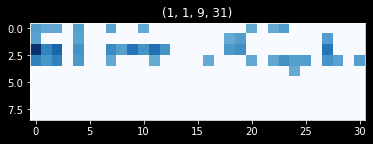



partial shuffle
1.25 oz wiskey
0.00 oz sugar cube
0.00 oz egg


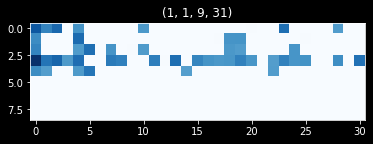



partial shuffle
0.76 oz egg
1.71 oz sugar cube
0.00 oz tomato juice


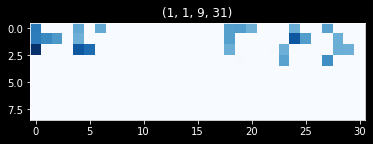



partial shuffle
1.51 oz vodka
0.00 oz egg
0.00 oz tomato juice


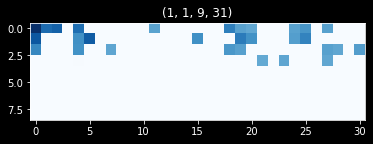



partial shuffle
0.86 oz white rum
0.47 oz lime
0.00 oz egg


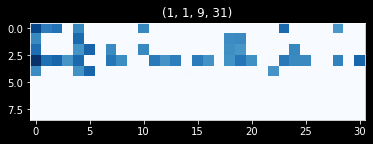



partial shuffle
0.33 oz jalapeno
1.47 oz wiskey
0.00 oz egg


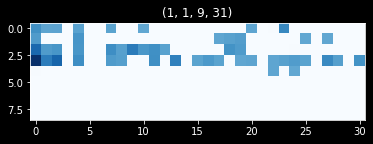



partial shuffle
0.00 oz egg


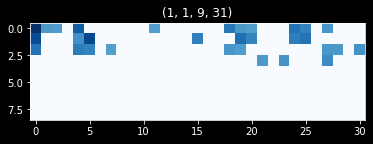



partial shuffle
0.66 oz white rum
0.14 oz egg


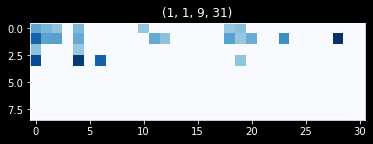



partial shuffle
1.84 oz gin
0.02 oz egg


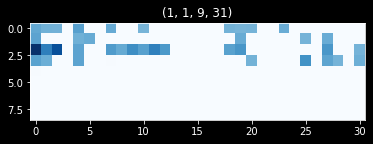



partial shuffle
1.69 oz white rum
0.00 oz egg


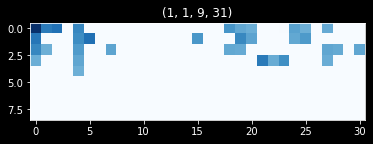



no shuffle
1.75 oz sugar cube
1.51 oz vodka
0.00 oz egg


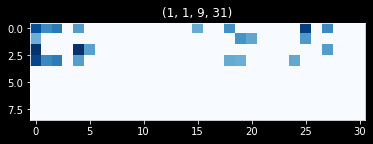



no shuffle
1.53 oz gin
0.00 oz egg


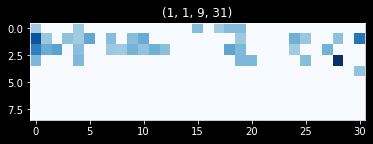



no shuffle
1.81 oz sugar cube
2.70 oz white rum
0.29 oz orange juice
0.00 oz egg


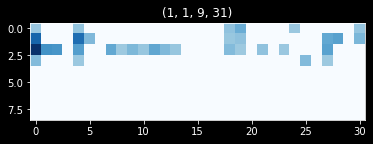



no shuffle
1.12 oz lime
0.00 oz egg


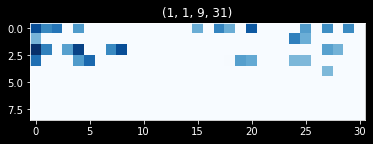



no shuffle
1.71 oz sugar cube
1.55 oz vodka
0.00 oz egg


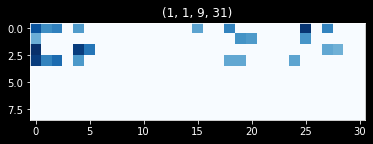



no shuffle
1.31 oz gin
0.00 oz egg


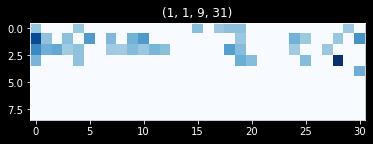



no shuffle
0.66 oz lime
0.21 oz egg
2.90 oz white rum


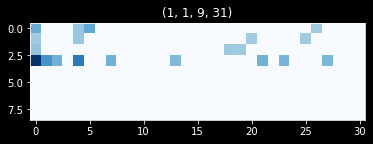



no shuffle
1.85 oz sugar cube
2.13 oz white rum
0.58 oz egg


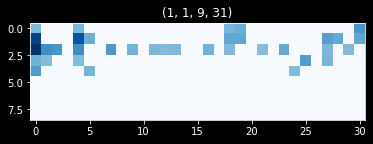



no shuffle
1.88 oz gin
0.00 oz egg


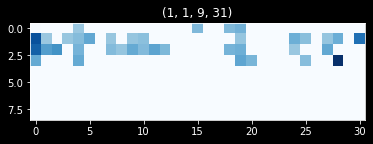



no shuffle
2.05 oz white rum
0.00 oz egg


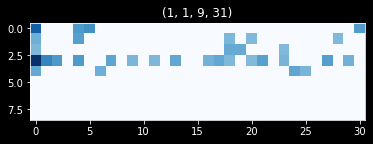

In [220]:
for model_data in models.values():
    if model_data["activated"] :
        for i in range(10) :
            noise = torch.randn(1,100, 1, 1, device=device)
            with torch.no_grad():
                print(model_data["name"])
                generator=model_data["generator"]
                generated=generator(noise)
                print_recipe_vals(generated.cpu().detach(),4)
                print_data(generated.cpu().detach())
                print("\n")